# Creating paramfiles for the ameriflux PPE
- 200 latin hypercube samples of a 20-d paramspace

In [1]:
import numpy as np
import xarray as xr
import os
import pandas as pd

In [3]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_tools import Ensemble,Member,ParamInfo
from ppe_tools.utils import get_default, parse_val

In [4]:
#this is the base paramfile that I will copy and edit
#important that the paramfile matches the version of CTSM
basefile = '/glade/scratch/djk2120/PPEn11/paramfiles/OAAT0000.nc'

#where to write the new files:
paramdir = '/glade/scratch/djk2120/PPEn11/amflx_lhc/paramfiles/'
nldir    = '/glade/scratch/djk2120/PPEn11/amflx_lhc/namelist_mods/'
lhckey   = '/glade/scratch/djk2120/PPEn11/amflx_lhc/lhc_220506.txt'

#make the directories, if needed 
for d in [paramdir,nldir]:
    if ~os.path.isdir(d):
        os.system('mkdir -p '+d)

In [6]:
#read in the spreadsheet
# have to publish the spreadsheet
###  file > share > publish to web > csv
csv = 'may06.csv'
if not os.path.isfile(csv):
    #data_url needs to be '"foo.bar"'
    data_url = '"https://docs.google.com/spreadsheets/d/e/2PACX-1vQbnPXdKgC4HjYddGl7qOUM6jxTqgqin2uoU2YU5wvbrpbWRuF53PU0k-Dz_Hg445v9yUsROSFEwYDq/pub?gid=1732324005&single=true&output=csv"'
    cmd = 'curl -L '+data_url+' > '+csv
    os.system(cmd)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   461    0   461    0     0   1748      0 --:--:-- --:--:-- --:--:--  1746
100  6746    0  6746    0     0   7989      0 --:--:-- --:--:-- --:--:--  7989


In [7]:
#proccess csv
data = pd.read_csv(csv) # modify read_csv to account for header spanning 2 rows
included = data['final']=='1'
## make sure to match your columns with the names
cols = ['name','loc','min','max','pft_mins','pft_maxs']
params_full = data.loc[included,cols]
params = params_full.reset_index(drop=True) # reset indexing and get rid of excel row number
params

,name,loc,min,max,pft_mins,pft_maxs
0,act25,P,40,120,NaN,NaN
1,baseflow_scalar,N,0.0005,0.1,NaN,NaN
2,cv,P,0.005,0.02,NaN,NaN
3,d_max,P,10,60,NaN,NaN
4,dleaf,P,pft,pft,"0,0.000216,0.000216,0.00072,0.0081,0.0081,0.00...","0,0.00108,0.00108,0.0036,0.0567,0.0567,0.243,0..."
5,fff,P,0.02,5,NaN,NaN
6,frac_sat_soil_dsl_init,P,0.5,1,NaN,NaN
7,hksat_sf,P,0.1,10,NaN,NaN
8,jmaxb0,P,0.01,0.05,NaN,NaN
9,kmax,P,pft,pft,"0,3.00E-09,4.00E-09,3.40E-09,1.50E-08,1.30E-08...","0,3.80E-08,3.40E-08,3.10E-08,1.70E-07,1.90E-07..."


In [9]:
#create the lhc dictionary
lhcs ={}
paramlist =  params['name'].values
for p in paramlist:
    ix = params['name']==p
    pinfo={}
    pinfo['loc']=params['loc'][ix].values[0]
    pinfo['flagged']=[]  #not using flags here
    for m in ['min','max']:
        mval = params[m][ix].values[0]
        if mval=='pft':
            pftval  = params['pft_'+m+'s'][ix].values[0]
            formatted = np.fromstring(pftval, dtype='float', sep=',')
        elif 'percent' in mval:
            formatted = mval
        else:
            formatted = np.array(float(mval))    

        pinfo[m]=formatted

    lhcs[p] = pinfo



In [10]:
#instantiate the Ensemble object
x    = Ensemble(basefile,paramdir,nldir)

#add the new OAATS
prefix = 'LHC'
nextnum=1
n_samples=250
x.add_lhcs(lhcs,prefix,nextnum,n_samples)

#write the ensemble
x.write(lhcfile=lhckey,default_key='LHC0000')

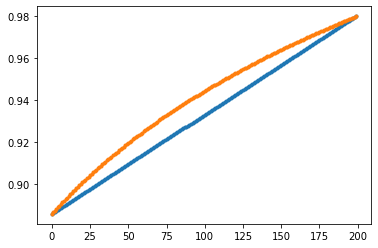

In [ ]:
rpb0 = 0.886
rpb1 = 0.98
d0 = np.log(0.05)/np.log(rpb0)
d1 = np.log(0.05)/np.log(rpb1)
drpb = rpb1-rpb0
rpbs2 = rpb0+np.log(np.linspace(1,np.exp(1),200))*drpb
d95s2 = np.log(0.05)/np.log(rpbs)
plt.plot(rpbs,'.')
plt.plot(rpbs2,'.')



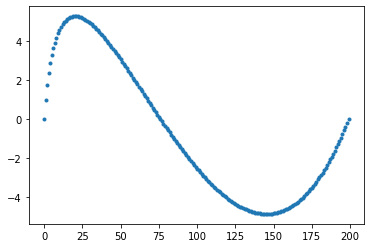

In [82]:
d95s2 = d0+(d1-d0)*np.linspace(0,1,200)
rpbs2 = 0.05**(1/d95s2)

lhc   = np.log(np.linspace(1,70,200))
lhc   = lhc/lhc.max()
rpbs3 = rpb0+(rpb1-rpb0)*lhc

d95s3 = np.log(0.05)/np.log(rpbs3)
plt.plot(d95s3-d95s2,'.')


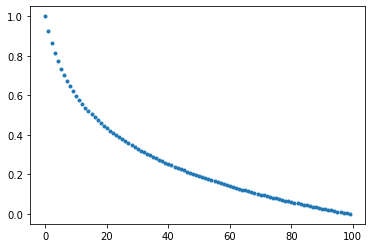

In [96]:
c=30
nx=100
wts = 1-np.log(np.linspace(1,c,nx))/np.log(c)

plt.plot(wts,'.')



In [55]:
np.exp(np.log(0.05))

0.05000000000000001

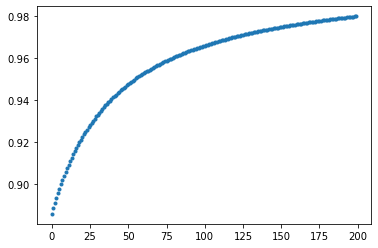

In [53]:
plt.plot(rpbs,'.')

In [18]:
import matplotlib.pyplot as plt

In [20]:
help(np.arange)

Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None, *, like=None)
    
    Return evenly spaced values within a given interval.
    
    Values are generated within the half-open interval ``[start, stop)``
    (in other words, the interval including `start` but excluding `stop`).
    For integer arguments the function is equivalent to the Python built-in
    `range` function, but returns an ndarray rather than a list.
    
    When using a non-integer step, such as 0.1, the results will often not
    be consistent.  It is better to use `numpy.linspace` for these cases.
    
    Parameters
    ----------
    start : integer or real, optional
        Start of interval.  The interval includes this value.  The default
        start value is 0.
    stop : integer or real
        End of interval.  The interval does not include this value, except
        in some cases where `step` is not an integer and floating point
        round-off 

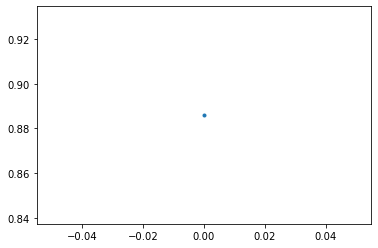

In [19]:
plt.plot(rpbs,'.')

### examine a pft file

In [5]:
ds = xr.open_dataset(basefile)

In [6]:
ds.kmax

<xarray.DataArray 'kmax' (segment: 4, pft: 79)>
array([[0.000000e+00, 1.602140e-08, 2.234574e-08, ..., 2.000000e-08,
        2.000000e-08, 2.000000e-08],
       [0.000000e+00, 1.602140e-08, 2.234574e-08, ..., 2.000000e-08,
        2.000000e-08, 2.000000e-08],
       [0.000000e+00, 1.602140e-08, 2.234574e-08, ..., 2.000000e-08,
        2.000000e-08, 2.000000e-08],
       [0.000000e+00, 1.602140e-08, 2.234574e-08, ..., 2.000000e-08,
        2.000000e-08, 2.000000e-08]])
Coordinates:
    pftname  (pft) |S40 ...
  * segment  (segment) |S40 b'sunlit                                  ' ... b...
Dimensions without coordinates: pft
Attributes:
    units:      mm h2o (transpired)/mm h2o (water potential gradient)/sec
    long_name:  plant segment max conductance

In [12]:
ds.medlynslope

<xarray.DataArray 'medlynslope' (pft: 79)>
array([0.  , 2.35, 2.35, 2.35, 4.12, 4.12, 4.45, 4.45, 4.45, 4.7 , 4.7 , 4.7 ,
       2.22, 5.25, 1.62, 5.79, 5.79, 1.79, 1.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 1.79, 1.79, 5.79, 5.79, 1.79,
       1.79, 1.79, 1.79, 1.79, 1.79, 5.79, 5.79])
Coordinates:
    pftname  (pft) |S40 b'not_vegetated                           ' ... b'irr...
Dimensions without coordinates: pft
Attributes:
    long_name:  Medlyn slope of conductance-photosynthesis relationship
    units:      umol H2O/umol CO2
    comment:    Values come from the values used in the CABLE model

In [13]:
ds.jmaxb0

<xarray.DataArray 'jmaxb0' ()>
array(0.0311)
Attributes:
    long_name:  Baseline proportion of nitrogen allocated for electron transport
    units:      J

## edit a paramfile
 - avoiding xarray for writing the new files, for some reason paramfiles written with xarray tend to crash the model

### jmaxb0, increase to 0.05

In [22]:
## CREATE the new paramfile
newfile = 'jmaxb0_5e-2.nc'
cmd = 'cp '+basefile+' '+newfile
os.system(cmd)

0

In [25]:
param = 'jmaxb0'
dset = netCDF4.Dataset(newfile,'r+')
dset[param][:] = 0.05
dset.close()

In [26]:
xr.open_dataset(newfile)['jmaxb0']

<xarray.DataArray 'jmaxb0' ()>
array(0.05)
Attributes:
    long_name:  Baseline proportion of nitrogen allocated for electron transport
    units:      J

### kmax, double all values
 - note that the shapes of the various parameters vary
 - some are scalar, some have a pft-dimension, and some have pft and plant-segment dimensions
 - easist to read in the example from basefile, and edit accordingly 

In [33]:
## CREATE the new paramfile
newfile = 'kmax_2x.nc'
cmd = 'cp '+basefile+' '+newfile
os.system(cmd)

0

In [35]:
param = 'kmax'
kmax = xr.open_dataset(basefile)[param].values
newkmax = kmax*2

In [36]:
dset = netCDF4.Dataset(newfile,'r+')
dset[param][:] = newkmax
dset.close()

In [37]:
xr.open_dataset(newfile)['kmax']

<xarray.DataArray 'kmax' (segment: 4, pft: 79)>
array([[0.000000e+00, 3.204280e-08, 4.469149e-08, ..., 4.000000e-08,
        4.000000e-08, 4.000000e-08],
       [0.000000e+00, 3.204280e-08, 4.469149e-08, ..., 4.000000e-08,
        4.000000e-08, 4.000000e-08],
       [0.000000e+00, 3.204280e-08, 4.469149e-08, ..., 4.000000e-08,
        4.000000e-08, 4.000000e-08],
       [0.000000e+00, 3.204280e-08, 4.469149e-08, ..., 4.000000e-08,
        4.000000e-08, 4.000000e-08]])
Coordinates:
    pftname  (pft) |S40 ...
  * segment  (segment) |S40 b'sunlit                                  ' ... b...
Dimensions without coordinates: pft
Attributes:
    units:      mm h2o (transpired)/mm h2o (water potential gradient)/sec
    long_name:  plant segment max conductance

### medlynslope
- substituting a value for just one pft

In [48]:
p = xr.open_dataset(basefile)
mypft = 'broadleaf_deciduous_temperate_tree'
ix    = np.array([mypft in str(n) for n in p.pftname.values])  #index vector for mypft

In [53]:
param = 'medlynslope'
m = p[param].values
m[ix] = 6
m

array([0.        , 2.3499999 , 2.3499999 , 2.3499999 , 4.11999989,
       4.11999989, 4.44999981, 6.        , 4.44999981, 4.69999981,
       4.69999981, 4.69999981, 2.22000003, 5.25      , 1.62      ,
       5.78999996, 5.78999996, 1.78999996, 1.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 5.78999996, 5.78999996, 5.78999996,
       5.78999996, 5.78999996, 1.78999996, 1.78999996, 5.78999996,
       5.78999996, 1.78999996, 1.78999996, 1.78999996, 1.78999

In [54]:
newfile = 'medlynslope_BDT_6.nc'
cmd = 'cp '+basefile+' '+newfile
os.system(cmd)
dset = netCDF4.Dataset(newfile,'r+')
dset[param][:] = m
dset.close()

In [55]:
xr.open_dataset(newfile)[param]

<xarray.DataArray 'medlynslope' (pft: 79)>
array([0.  , 2.35, 2.35, 2.35, 4.12, 4.12, 4.45, 6.  , 4.45, 4.7 , 4.7 , 4.7 ,
       2.22, 5.25, 1.62, 5.79, 5.79, 1.79, 1.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79,
       5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 5.79, 1.79, 1.79, 5.79, 5.79, 1.79,
       1.79, 1.79, 1.79, 1.79, 1.79, 5.79, 5.79])
Coordinates:
    pftname  (pft) |S40 ...
Dimensions without coordinates: pft
Attributes:
    long_name:  Medlyn slope of conductance-photosynthesis relationship
    units:      umol H2O/umol CO2
    comment:    Values come from the values used in the CABLE model